In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load files

In [2]:
# Function to apply a low-pass filter
def apply_low_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to add temporal features
def add_temporal_features(df, lags, rolling_windows):
    for feature in df.columns:
        if feature not in ['time', 'label']:
            for lag in lags:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            for window in rolling_windows:
                df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window).mean()
                df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window).std()
                df[f'{feature}_ewma'] = df[feature].ewm(span=7).mean()
    df.dropna(inplace=True)
    return df

# Function to compute FFT features
def compute_fft_features(df, columns):
    fft_features = {}
    for col in columns:
        fft_vals = np.fft.fft(df[col].values)
        fft_features[f'{col}_fft_real'] = np.real(fft_vals)
        fft_features[f'{col}_fft_imag'] = np.imag(fft_vals)
        fft_features[f'{col}_fft_abs'] = np.abs(fft_vals)
    return pd.DataFrame(fft_features, index=df.index)

# Load training and testing data
train_data_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/'
test_data_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_40min_test/'

train_accel_data = pd.read_csv(train_data_path + 'Combined_accelerometer_100min.csv')
train_gyro_data = pd.read_csv(train_data_path + 'Combined_gyroscope_100min.csv')
train_linear_accel_data = pd.read_csv(train_data_path + 'Combined_linear_accelerometer_100min.csv')
train_magnetometer_data = pd.read_csv(train_data_path + 'Combined_magnetometer_100min.csv')

test_accel_data = pd.read_csv(test_data_path + 'Combined_accelerometer_40min.csv')
test_gyro_data = pd.read_csv(test_data_path + 'Combined_gyroscope_40min.csv')
test_linear_accel_data = pd.read_csv(test_data_path + 'Combined_linear_accelerometer_40min.csv')
test_magnetometer_data = pd.read_csv(test_data_path + 'Combined_magnetometer_40min.csv')

# Combine all data into one dataframe for training and testing
combined_train_data = pd.merge(train_accel_data, train_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_train_data = pd.merge(combined_train_data, train_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_train_data = pd.merge(combined_train_data, train_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

combined_test_data = pd.merge(test_accel_data, test_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_test_data = pd.merge(combined_test_data, test_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_test_data = pd.merge(combined_test_data, test_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

# Apply low-pass filter
cutoff_frequency = 0.5  # Cutoff frequency in Hz
fs = 2  # Sampling frequency in Hz
order = 5  # Filter order

for column in combined_train_data.columns:
    if column not in ['time', 'label']:
        combined_train_data[column] = apply_low_pass_filter(combined_train_data[column], cutoff_frequency, fs, order)
        combined_test_data[column] = apply_low_pass_filter(combined_test_data[column], cutoff_frequency, fs, order)

# Pre-processed sensor data
feature_columns = combined_train_data.columns.difference(['time', 'label'])
X_train_sensor = combined_train_data[feature_columns]
y_train = combined_train_data['label']

X_test_sensor = combined_test_data[feature_columns]
y_test = combined_test_data['label']

# Sensor + Temporal Data
lags = [5, 7, 10]
rolling_windows = [5, 7, 10]


combined_train_data_temporal = add_temporal_features(combined_train_data.copy(), lags, rolling_windows)
combined_test_data_temporal = add_temporal_features(combined_test_data.copy(), lags, rolling_windows)

feature_columns_temporal = combined_train_data_temporal.columns.difference(['time', 'label'])
X_train_temporal = combined_train_data_temporal[feature_columns_temporal]
y_train_temporal = combined_train_data_temporal['label']

X_test_temporal = combined_test_data_temporal[feature_columns_temporal]
y_test_temporal = combined_test_data_temporal['label']

# Sensor + Fourier Transformations
fft_columns = combined_train_data.columns.difference(['time', 'label'])
fft_train_data = compute_fft_features(combined_train_data, fft_columns).dropna()
fft_test_data = compute_fft_features(combined_test_data, fft_columns).dropna()

feature_columns_fft = fft_train_data.columns
X_train_fft = fft_train_data
y_train_fft = combined_train_data['label']  # Same labels

X_test_fft = fft_test_data
y_test_fft = combined_test_data['label']  # Same labels

# Apply PCA after feature engineering
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

n_components = 3  # Number of principal components to keep

# PCA on temporal features
X_train_temporal_pca, X_test_temporal_pca = apply_pca(X_train_temporal, X_test_temporal, n_components)

# PCA on Fourier features
X_train_fft_pca, X_test_fft_pca = apply_pca(X_train_fft, X_test_fft, n_components)

# PCA on Sensor + Temporal Features
X_train_sensor_temporal_combined = pd.concat([X_train_sensor, X_train_temporal], axis=1).dropna()
X_test_sensor_temporal_combined = pd.concat([X_test_sensor, X_test_temporal], axis=1).dropna()

y_train_sensor_temporal_combined = y_train.loc[X_train_sensor_temporal_combined.index]
y_test_sensor_temporal_combined = y_test.loc[X_test_sensor_temporal_combined.index]

X_train_sensor_temporal_pca, X_test_sensor_temporal_pca = apply_pca(
    X_train_sensor_temporal_combined,
    X_test_sensor_temporal_combined,
    n_components
)

# PCA on Sensor + Fourier Transformations
X_train_sensor_fft_combined = pd.concat([X_train_sensor, X_train_fft], axis=1).dropna()
X_test_sensor_fft_combined = pd.concat([X_test_sensor, X_test_fft], axis=1).dropna()

y_train_sensor_fft_combined = y_train.loc[X_train_sensor_fft_combined.index]
y_test_sensor_fft_combined = y_test.loc[X_test_sensor_fft_combined.index]

X_train_sensor_fft_pca, X_test_sensor_fft_pca = apply_pca(
    X_train_sensor_fft_combined,
    X_test_sensor_fft_combined,
    n_components
)

# PCA on Fourier + Temporal Features
X_train_fourier_temporal_combined = pd.concat([X_train_temporal, X_train_fft], axis=1).dropna()
X_test_fourier_temporal_combined = pd.concat([X_test_temporal, X_test_fft], axis=1).dropna()

y_train_fourier_temporal_combined = y_train.loc[X_train_fourier_temporal_combined.index]
y_test_fourier_temporal_combined = y_test.loc[X_test_fourier_temporal_combined.index]

X_train_fourier_temporal_pca, X_test_fourier_temporal_pca = apply_pca(
    X_train_fourier_temporal_combined,
    X_test_fourier_temporal_combined,
    n_components
)

# PCA on Sensor + Temporal + Fourier Features
X_train_all_combined = pd.concat([X_train_sensor, X_train_temporal, X_train_fft], axis=1).dropna()
X_test_all_combined = pd.concat([X_test_sensor, X_test_temporal, X_test_fft], axis=1).dropna()

y_train_all_combined = y_train.loc[X_train_all_combined.index]
y_test_all_combined = y_test.loc[X_test_all_combined.index]

X_train_all_pca, X_test_all_pca = apply_pca(
    X_train_all_combined,
    X_test_all_combined,
    n_components
)



In [3]:
def train_and_evaluate_rf_with_pca(X_train_pca, y_train, X_test_pca, y_test, model_params, title):
    rf_model = RandomForestClassifier(**model_params)
    rf_model.fit(X_train_pca, y_train)
    
    y_pred = rf_model.predict(X_test_pca)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['clapping', 'handshake', 'highfive', 'wave'])
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    return rf_model

model_params = {
    'n_estimators': 150,
    'max_depth': 17,
    'min_samples_split': 9,
    'min_samples_leaf': 1,
    'criterion': 'gini',
    'max_features': 'log2',
    'random_state': 55
}

# Model 1: Pre-processed Sensor Data (No PCA)
print("Model 1: Pre-processed Sensor Data")
rf_model_sensor = train_and_evaluate_rf_with_pca(X_train_sensor, y_train, X_test_sensor, y_test, model_params, "Feature Importance (Pre-processed Sensor Data)")

# Model 2: Temporal Features Only
print("Model 2: Temporal Features Only")
rf_model_temporal_only_pca = train_and_evaluate_rf_with_pca(X_train_temporal_pca, y_train_temporal, X_test_temporal_pca, y_test_temporal, model_params, "Feature Importance (Temporal Features Only with PCA)")

# Model 3: Fourier Transformation Only
print("Model 3: Fourier Transformation Only")
rf_model_fft_only_pca = train_and_evaluate_rf_with_pca(X_train_fft_pca, y_train_fft, X_test_fft_pca, y_test_fft, model_params, "Feature Importance (Fourier Transformation Only with PCA)")

# Model 4: Sensor + Temporal Features
print("Model 4: Sensor + Temporal Features")
rf_model_sensor_temporal_pca = train_and_evaluate_rf_with_pca(X_train_sensor_temporal_pca, y_train_sensor_temporal_combined, X_test_sensor_temporal_pca, y_test_sensor_temporal_combined, model_params, "Feature Importance (Sensor + Temporal Features with PCA)")

# Model 5: Sensor + Fourier Transformations
print("Model 5: Sensor + Fourier Transformations")
rf_model_sensor_fft_pca = train_and_evaluate_rf_with_pca(X_train_sensor_fft_pca, y_train_sensor_fft_combined, X_test_sensor_fft_pca, y_test_sensor_fft_combined, model_params, "Feature Importance (Sensor + Fourier Transformations with PCA)")

# Model 6: Fourier + Temporal Features
print("Model 6: Fourier + Temporal Features")
rf_model_fourier_temporal_pca = train_and_evaluate_rf_with_pca(X_train_fourier_temporal_pca, y_train_fourier_temporal_combined, X_test_fourier_temporal_pca, y_test_fourier_temporal_combined, model_params, "Feature Importance (Fourier + Temporal Features with PCA)")

# Model 7: Sensor + Temporal + Fourier Features
print("Model 7: Sensor + Temporal + Fourier Features")
rf_model_all_pca = train_and_evaluate_rf_with_pca(X_train_all_pca, y_train_all_combined, X_test_all_pca, y_test_all_combined, model_params, "Feature Importance (Sensor + Temporal + Fourier Features with PCA)")


Model 1: Pre-processed Sensor Data
Accuracy: 0.5878
Confusion Matrix:
[[663 526   0   1]
 [857 335   4   1]
 [  2  14 950 228]
 [258   3  71 854]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.37      0.56      0.45      1190
   handshake       0.38      0.28      0.32      1197
    highfive       0.93      0.80      0.86      1194
        wave       0.79      0.72      0.75      1186

    accuracy                           0.59      4767
   macro avg       0.62      0.59      0.59      4767
weighted avg       0.62      0.59      0.59      4767

Model 2: Temporal Features Only
Accuracy: 0.1657
Confusion Matrix:
[[  56    1 1133    0]
 [ 352  728  107    0]
 [ 271  734    2  187]
 [1123    0   61    2]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.03      0.05      0.04      1190
   handshake       0.50      0.61      0.55      1187
    highfive       0.00      0.00      0.00      

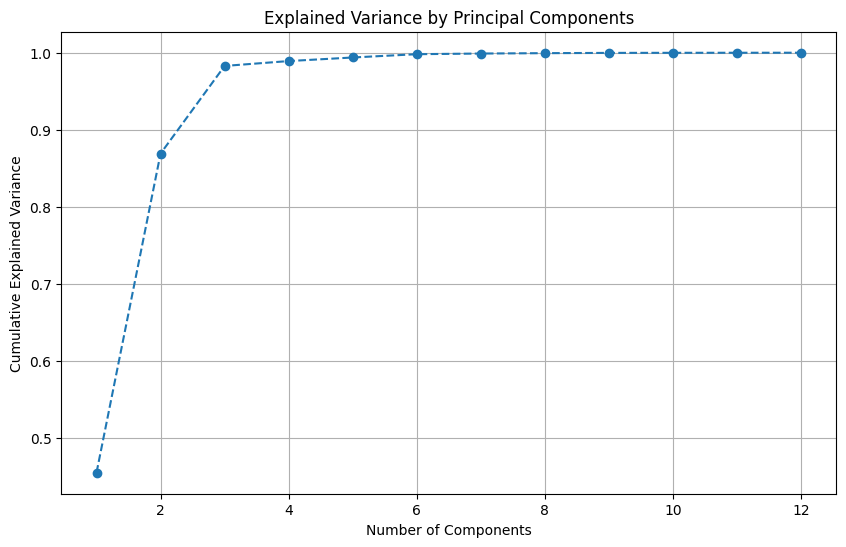

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_explained_variance(X_train):
    pca = PCA()
    pca.fit(X_train)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Principal Components')
    plt.grid(True)
    plt.show()

# Plot explained variance for one of the datasets
plot_explained_variance(X_train_sensor)
